# Tutorial: advection-diffusion kernels in Parcels
In Eulerian ocean models, sub-grid scale dispersion of tracers such as heat, salt, or nutrients is often parameterized as a diffusive process. In Lagrangian particle simulations, sub-grid scale effects can be parameterized as a stochastic process, randomly displacing a particle position in proportion to the local eddy diffusivity ([Van Sebille et al. 2018](https://doi.org/10.1016/j.ocemod.2017.11.008)). Parameterizing sub-grid scale dispersion may be especially important when coarse velocity fields are used that do not resolve mesoscale eddies ([Shah et al., 2017](https://doi.org/10.1175/JPO-D-16-0098.1)). This tutorial explains how to use a sub-grid scale parameterization in _Parcels_ that is consistent with the advection-diffusion equation used in Eulerian models.

## Stochastic differential equations (SDE) consistent with advection-diffusion
The time-evolution of a stochastic process is described by a stochastic differential equation. The time-evolution of the conditional probability density of a stochastic process is described by a Fokker-Planck equation (FPE). The advection-diffusion equation, describing the evolution of a tracer, can be written as a Fokker-Planck equation. Therefore, we can formulate a stochastic differential equation for a particle in the Lagrangian frame undergoing advection with stochastic noise proportional to the local diffusivity in a way that is consistent with advection-diffusion in the Eulerian frame. For details, see [Shah et al., 2011](https://doi.org/10.1016/j.ocemod.2011.05.008) and [van Sebille et al., 2018](https://doi.org/10.1016/j.ocemod.2017.11.008).

The stochastic differential equation for a particle trajectory including diffusion is
$$
\begin{aligned}
    d\mathbf{X}(t) &\overset{\text{Îto}}{=} (\mathbf{u} + \nabla \cdot \mathbf{K}) dt + \mathbf{V}(t, \mathbf{X})\cdot d\mathbf{W}(t), \\
    \mathbf{X}(t_0) &= \mathbf{x}_0,
\end{aligned}
$$
where $\mathbf{X}$ is the particle position vector ($\mathbf{x}_0$ being the initial position vector), $\mathbf{u}$ the velocity vector, $\mathbf{K} = \frac{1}{2} \mathbf{V} \cdot \mathbf{V}^T$ the diffusivity tensor, and $d\mathbf{W}(t)$ a Wiener increment (normally distributed with zero mean and variance $dt$). Particle distributions obtained by solving the above equation are therefore consistent with Eulerian concentrations found by solving the advection-diffusion equation. 

In three-dimensional ocean models diffusion operates along slopes of neutral buoyancy. To account for these slopes, the 3D diffusivity tensor $\mathbf{K}$ (and therefore $\mathbf{V}$) contains off-diagonal components. Three-dimensional advection-diffusion is not yet implemented in _Parcels_, but it is currently under development. Here we instead focus on the simpler case of diffusion in a horizontal plane, where diffusivity is specified only in the zonal and meridional direction, i.e. 
$$\mathbf{K}(x,y)=\begin{bmatrix}
K_x(x,y) & 0\\
0 & K_y(x,y)
\end{bmatrix}.$$ 

The above stochastic differential equation then becomes 

$$
\begin{align}
    dX(t) &= a_x dt + b_x dW_x(t), \quad &X(t_0) = x_0,\\
    dY(t) &= a_y dt + b_y dW_y(t), \quad &Y(t_0) = y_0,
\end{align}
$$
where $a_i = v_i + \partial_i K_i(x, y)$ is the deterministic drift term and $b_i = \sqrt{2K_i(x, y)}$ a stochastic noise term ($\partial_i$ denotes the partial derivative with respect to $i$).

## Numerical Approximations of SDEs
The simplest numerical approximation of the above SDEs is obtained by replacing $dt$ by a finite time discrete step $\Delta t$ and $dW$ by a discrete increment $\Delta W$, yielding the **Euler-Maruyama (EM) scheme** ([Maruyama, 1955](https://link.springer.com/article/10.1007/BF02846028)):
$$
\begin{equation}
    X_{n+1} = X_n + a_x \Delta t + b_x \Delta W_{n, x},
\end{equation}
$$
with a similar expression for $Y$.

A higher-order scheme is found by including extra terms from a Taylor expansion on our SDE, yielding the **Milstein scheme of order 1 (M1)**:
$$
\begin{equation}
    X_{n+1} = X_n + a_x \Delta t + b_x \Delta W_x + \frac{1}{2}b_x \partial_x b_x(\Delta W_{n, x}^2 - \Delta t),
\end{equation}
$$
which can be rewritten by explicitly writing $b_x\partial_x b_x$ as $\partial_x K_x(z)$: 
$$
\begin{equation}
    X_{n+1} = X_n + v_x \Delta t + \frac{1}{2}\partial_x K_x(\Delta W_{n, x}^2 + \Delta t) + b\Delta W_n.
\end{equation}
$$
The extra term in the M1 scheme provides extra accuracy at negligible computational cost.

The spatial derivatives in the EM and M1 schemes can be approximated by a central difference. Higher order numerical schemes (see [Gräwe et al., 2012](https://doi.org/10.1007/s10236-012-0523-y)) include higher order derivatives. Since Parcels uses bilinear interpolation, these higher order derivatives cannot be computed, meaning that higher order numerical schemes cannot be used.

An overview of numerical approximations for SDEs in a particle tracking setting can be found in [Gräwe (2011)](https://doi.org/10.1016/j.ocemod.2010.10.002).

## Using Advection-Diffusion Kernels in Parcels
The EM and M1 advection-diffusion approximations are available as `AdvectionDiffusionEM` and `AdvectionDiffusionM1`, respectively. The `AdvectionDiffusionM1` kernel should be the default choice, as the increased accuracy comes at negligible computational cost. 

The advection component of these kernels is similar to that of the Explicit Euler advection kernel (`AdvectionEE`). In the special case where diffusivity is constant over the entire domain, the diffusion-only kernel `DiffusionUniformKh` can be used in combination with an advection kernel of choice. Since the diffusivity here is space-independent, gradients are not calculated, increasing efficiency. The diffusion-step can in this case be computed after or before advection, thus allowing you to chain kernels using the `+` operator.

Just like velocities, diffusivities are passed to Parcels in the form of `Field` objects. When using `DiffusionUniformKh`, they should be added to the `FieldSet` object as constant fields, e.g. `fieldset.add_constant_field("Kh_zonal", 1, mesh="flat")`.

To make a central difference approximation for computing the gradient in diffusivity, a resolution for this approximation `dres` is needed: _Parcels_ approximates the gradients in diffusivities by using their values at the particle's location ± `dres` (in both $x$ and $y$). A value of `dres` must be specified and added to the FieldSet by the user (e.g. `fieldset.add_constant("dres", 0.01)`). Currently, it is unclear what the best value of `dres` is. From experience, its size of `dres` should be smaller than the spatial resolution of the data, but within reasonable limits of machine precision to avoid numerical errors. We are working on a method to compute gradients differently so that specifying `dres` is not necessary anymore.

## Example: Impermeable Diffusivity Profile

Let's see the `AdvectionDiffusionM1` in action and see why it's preferable over the `AdvectionDiffusionEM` kernel. To do so, we create an idealized profile with diffusivities $K_\text{zonal}$ uniform everywhere ($K_\text{zonal} = \bar{K}=0.5$) and $K_\text{meridional}$ constant in the zonal direction, while having the following profile in the meridional direction:

$$ K_\text{meridional}(y) = \bar{K}\frac{2(1+\alpha)(1+2\alpha)}{\alpha^2H^{1+1/\alpha}} \begin{cases}
y(L-2y)^{1/\alpha},\quad 0 \leq y \leq L/2,\\
(L-y)(2y-1)^{1/a},\quad H/2 \leq y \leq L,
\end{cases}$$
with $L$ being the basin length scale, $\alpha$ as a parameter determining the steepness in the gradient in the profile. This profile is similar to that used by [Gräwe (2011)](https://doi.org/10.1016/j.ocemod.2010.10.002), now used in the meridional direction for illustrative purposes.

Let's plot $K_\text{meridional}(y)$:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import timedelta
from parcels import ParcelsRandom
from parcels import (FieldSet, ParticleSet, JITParticle,
                     DiffusionUniformKh, AdvectionDiffusionM1, AdvectionDiffusionEM)

In [2]:
K_bar = 0.5   # Average diffusivity
alpha = 1.    # Profile steepness
L = 1.        # Basin scale
Ny = 103      # Number of grid cells in y_direction (101 +2, one level above and one below, where fields are set to zero)
dy = 1.03/Ny  # Spatial resolution
y = np.linspace(-0.01, 1.01, 103)  # y-coordinates for grid
y_K = np.linspace(0., 1., 101)     # y-coordinates used for setting diffusivity
beta = np.zeros(y_K.shape)         # Placeholder for fraction term in K(y) formula

for yi in range(len(y_K)):
    if y_K[yi] < L/2:
        beta[yi] = y_K[yi]*np.power(L - 2*y_K[yi], 1/alpha)
    elif y_K[yi] >= L/2:
        beta[yi] = (L - y_K[yi])*np.power(2*y_K[yi] - L, 1/alpha)
Kh_meridional = 0.1*(2*(1+alpha)*(1+2*alpha))/(alpha**2*np.power(L, 1+1/alpha))*beta
Kh_meridional = np.concatenate((np.array([0]), Kh_meridional, np.array([0])))

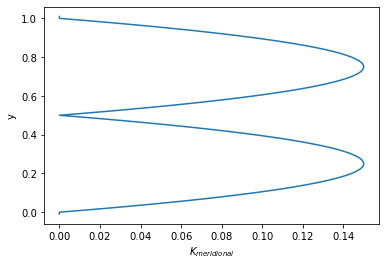

In [3]:
plt.plot(Kh_meridional, y)
plt.ylabel("y")
plt.xlabel(r"$K_{meridional}$")
plt.show()

In this profile, diffusivity drops to 0 at $y=0.5$ and at $y=0$ and $y=1$. In the absence of advection, particles starting out in one half of the domain should remain confined to that half as they are unable to cross the points where the diffusivity drops to 0. The line $y=0.5$ should therefore provide an impermeable barrier.

Now we can put this idealized profile into a flat fieldset:

In [4]:
xdim, ydim = (1, Ny)
data = {'U': np.zeros(ydim),
        'V': np.zeros(ydim),
        'Kh_zonal': K_bar*np.ones(ydim),
        'Kh_meridional':  Kh_meridional}
dims = {'lon': 1,
        'lat': np.linspace(-0.01, 1.01, ydim, dtype=np.float32)}
fieldset = FieldSet.from_data(data, dims, mesh='flat', allow_time_extrapolation=True)
fieldset.add_constant('dres', 0.00005)

We release 100 particles at ($x=0$, $y=0.75$).

In [5]:
def get_test_particles():
    return ParticleSet.from_list(fieldset,
                                 pclass=JITParticle,
                                 lon=np.zeros(100),
                                 lat=np.ones(100)*0.75,
                                 time=np.zeros(100),
                                 lonlatdepth_dtype=np.float64)

Now we will simulate the advection and diffusion of the particles using the `AdvectionDiffusionM1` kernel. We run the simulation for 0.3 seconds, with a numerical timestep $\Delta t = 0.001$s. We also write away particle locations at each timestep for plotting. Note that this will hinder a runtime comparison between kernels, since it will cause most time to be spent on I/O.

In [6]:
dt = 0.001
testParticles = get_test_particles()
output_file = testParticles.ParticleFile(name="M1_out.nc",
                                         outputdt=timedelta(seconds=dt))
ParcelsRandom.seed(1636)  # Random seed for reproducibility
testParticles.execute(AdvectionDiffusionM1,
                      runtime=timedelta(seconds=0.3),
                      dt=timedelta(seconds=dt),
                      output_file=output_file,
                      verbose_progress=True)
output_file.close()  # to write the output to a netCDF file, since `output_file` does not close automatically when using notebooks

INFO: Compiled ParcelsRandom ==> /var/folders/_k/jcmdplbn0yj79g4k3g9f4nxr0000gn/T/parcels-501/parcels_random_ac532b87-5b06-48d0-9e2d-255636be37a9.so
INFO: Compiled JITParticleAdvectionDiffusionM1 ==> /var/folders/_k/jcmdplbn0yj79g4k3g9f4nxr0000gn/T/parcels-501/898c1da8a616299b79df707e314fd48c_0.so
100% (0.3 of 0.3) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


In [7]:
M1_out = xr.open_dataset("M1_out.nc")

We can plot the individual coordinates of the particle trajectories against time ($x$ against $t$ and $y$ against $t$) to investigate how diffusion works along each axis.

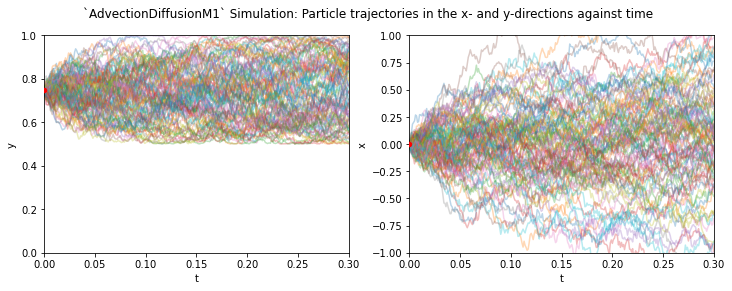

In [8]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

for data, ai, dim, ystart, ylim in zip([M1_out.lat, M1_out.lon], ax, ('y', 'x'), (0.75, 0), [(0, 1), (-1, 1)]):
    ai.plot(np.arange(0, 0.3002, 0.001), data.T, alpha=0.3)
    ai.scatter(0, ystart, s=20, c='r', zorder=3)
    ai.set_xlabel("t")
    ai.set_ylabel(dim)
    ai.set_xlim(0, 0.3)
    ai.set_ylim(ylim)

fig.suptitle("`AdvectionDiffusionM1` Simulation: Particle trajectories in the x- and y-directions against time")
plt.show()

We see that the along the meridional direction, particles remain confined to the ‘upper’ part of the domain, not crossing the impermeable barrier where the diffusivity drops to zero. In the zonal direction, particles follow random walks, since all terms involving gradients of the diffusivity are zero.

Now let's execute the simulation with the `AdvectionDiffusionEM` kernel instead. 

In [9]:
dt = 0.001
testParticles = get_test_particles()
output_file = testParticles.ParticleFile(name="EM_out.nc",
                                         outputdt=timedelta(seconds=dt))
ParcelsRandom.seed(1636)  # Random seed for reproducibility
testParticles.execute(AdvectionDiffusionEM,
                      runtime=timedelta(seconds=0.3),
                      dt=timedelta(seconds=dt),
                      output_file=output_file,
                      verbose_progress=True)
output_file.close()  # to write the output to a netCDF file, since `output_file` does not close automatically when using notebooks

INFO: Compiled JITParticleAdvectionDiffusionEM ==> /var/folders/_k/jcmdplbn0yj79g4k3g9f4nxr0000gn/T/parcels-501/e1c028fccbd72db1f946f5c3150bf1a9_0.so
100% (0.3 of 0.3) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


In [10]:
EM_out = xr.open_dataset("EM_out.nc")

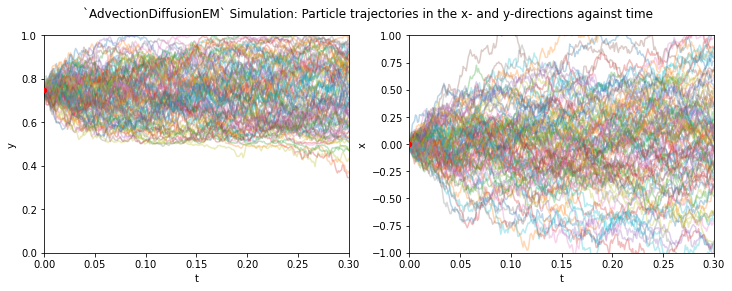

In [11]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

for data, ai, dim, ystart, ylim in zip([EM_out.lat, EM_out.lon], ax, ('y', 'x'), (0.75, 0), [(0, 1), (-1, 1)]):
    ai.plot(np.arange(0, 0.3002, 0.001), data.T, alpha=0.3)
    ai.scatter(0, ystart, s=20, c='r', zorder=3)
    ai.set_xlabel("t")
    ai.set_ylabel(dim)
    ai.set_xlim(0, 0.3)
    ai.set_ylim(ylim)

fig.suptitle("`AdvectionDiffusionEM` Simulation: Particle trajectories in the x- and y-directions against time")
plt.show()

The Wiener increments for both simulations are equal, as they are fixed through a random seed. As we can see, the Euler-Maruyama scheme performs worse than the Milstein scheme, letting particles cross the impermeable barrier at $y=0.5$. In contrast, along the zonal direction, particles follow the same random walk as in the Milstein scheme, which is expected since the extra terms in the Milstein scheme are zero in this case.

## References
Gräwe, U. (2011). “Implementation of high-order particle-tracking schemes in a water column model.” *Ocean Modelling*, 36(1), 80–89. https://doi.org/10.1016/j.ocemod.2010.10.002

Gräwe, Deleersnijder, Shah & Heemink (2012). “Why the Euler scheme in particle tracking is not enough: The shallow-sea pycnocline test case.” *Ocean Dynamics*, 62(4), 501–514. https://doi.org/10.1007/s10236-012-0523-y

Maruyama, G. (1955). “Continuous Markov processes and stochastic equations.” *Rendiconti del Circolo Matematico di Palermo*, 4(1), 48.

van Sebille et al. (2018). “Lagrangian ocean analysis: Fundamentals and practices.” *Ocean Modelling*, 121, 49–75. https://doi.org/10.1016/j.ocemod.2017.11.008

Shah, S. H. A. M., Heemink, A. W., & Deleersnijder, E. (2011). “Assessing Lagrangian schemes for simulating diffusion on non-flat isopycnal surfaces.” *Ocean Modelling*, 39(3–4), 351–361. https://doi.org/10.1016/j.ocemod.2011.05.008
 https://doi.org/10.1016/j.ocemod.2011.05.008

Shah, Primeau, Deleersnijder & Heemink (2017). “Tracing the Ventilation Pathways of the Deep North Pacific Ocean Using Lagrangian Particles and Eulerian Tracers.” *Journal of Physical Oceanography*, 47(6), 1261–1280. https://doi.org/10.1175/JPO-D-16-0098.1